## A notebook for fitting to ARMADA binary orbits

In [3]:
from lmfit import minimize, Minimizer, Parameters, Parameter, report_fit
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import random
from tqdm import tqdm
import matplotlib.cm as cm
from matplotlib.backends.backend_pdf import PdfPages
import emcee
import corner
from read_data import read_data,read_wds,read_orb6
from astrometry_model import astrometry_model,triple_model,lnlike,lnprior,lnpost,create_init
from orbit_plotting import orbit_model,triple_orbit_model
%matplotlib inline

In [4]:
if os.getcwd()[7:14] == 'tgardne':
    ## setup paths for user
    path = '/Users/tgardne/ARMADA_orbits'
    path_etalon = '/Users/tgardne/etalon_epochs/etalon_fits/etalon_factors_fit_SKY.txt'
    path_wds = '/Users/tgardne/wds_targets'
    path_orb6 = '/Users/tgardne/catalogs/orb6orbits.sql.txt'
    
elif os.getcwd()[7:19] == 'adam.scovera':
    ## Adam's path
    path = '/Users/adam.scovera/Documents/UofM/BEPResearch_Data/ARMADA_orbits'
    path_etalon = '/Users/adam.scovera/Documents/UofM/BEPResearch_Data/etalon_factors_fit.txt'
    path_wds = '/Users/adam.scovera/Documents/UofM/BEPResearch_Data/wds_targets'
    path_orb6 = '/Users/adam.scovera/Documents/UofM/BEPResearch_Data/orb6orbits.sql.txt'

## Specify a target HD number and WDS number

In [5]:
### give target information
# target is hip number
# target_hd is hd number
# target_wds is wds number

target = []
target_hd = []
target_wds = []

# Target 0 really nice
target.append('26536')
target_hd.append ('37269')
target_wds.append('05386+3030')

# Target 1 pretty nice
target.append('21644')
target_hd.append ('29573')
target_wds.append('04389-1207')

# Target 2 Has some problems: Obvious outliers
target.append('12828')
target_hd.append ('17094')
target_wds.append('02449+1007')

# Target 3 really nice
target.append('101398')
target_hd.append ('196089')
target_wds.append('20330+4950')

# Target 4 pretty nice
target.append('98055')
target_hd.append ('189037')
target_wds.append('19556+5226')

# Target 5 Obvious outliers
target.append('21730')
target_hd.append ('29316')
target_wds.append('04400+5328')

# Target 6 Really nice, possible outliers
target.append('26777')
target_hd.append ('37711')
target_wds.append('05413+1632')

# Target 7 Something is wrong, does not seem right
target.append('113788')
target_hd.append ('217782')
target_wds.append('23026+4245')

# Target 8 Overall good, some strange data points
target.append('5131')
target_hd.append ('6456')
target_wds.append('01057+2128')

# Target 9 Really Nice
target.append('12466')
target_hd.append('16753')
target_wds.append('02405-2408')

# Target 10 Not bad, hige residuals
target.append('4176')
target_hd.append('5143')
target_wds.append('00533+0405')

# Target 11 Really Nice
target.append('22573')
target_hd.append('31093')
target_wds.append('04515-3454')

# Target 12 Looks strange Maybe the dates are off in WDS?
target.append('30883') 
target_hd.append('45542')
target_wds.append('06290+2013')

# Target 13 Looks weird. Maybe the dates are off?
target.append('76852')
target_hd.append('140159')
target_wds.append('15416+1940')

# Target 14 WDS data not working
target.append('87761')
target_hd.append('163346')
target_wds.append('17556+0204')

# Target 15 Strange Results. Try Flipping
target.append('96729')
target_hd.append('185404')
target_wds.append('19398-2326')

# Target 16 Again, weird. Dates?
target.append('96807')
target_hd.append('185762')
target_wds.append('19407-0037')

# Target 17 Try Flipping
target.append('118205')
target_hd.append('224512')
target_wds.append('23586-1408')

# Target 18 WDS not working
target.append('101211')
target_hd.append('195206')
target_wds.append('20310-2907')

# Target 19 WDS not working
target.append('102589')
target_hd.append('198183')
target_wds.append('20474+3629')

# Target 20 Really nice. Possible outliers
target.append('104272')
target_hd.append('201038')
target_wds.append('21074-0814')

# Target 21 Nice, possible outliers
target.append('103569')
target_hd.append('199766')
target_wds.append('20591+0418')

# Iota Peg
target.append('109176')
target_hd.append('210027')
target_wds.append('22070+2521')

# Choose which index to focus on
focus = 0

## Read in ARMADA data

In [6]:
#Get data from txt file:
file=open('%s/HD_%s.txt'%(path,target_hd[focus]))
weight=1

t,p,theta,error_maj,error_min,error_pa,error_deg = read_data(file,weight)
file.close()

#idx = np.where(t>58362)
idx = np.where(t>0)
t = t[idx]
p = p[idx]
theta = theta[idx]
error_maj = error_maj[idx]
error_min = error_min[idx]
error_pa = error_pa[idx]
error_deg = error_deg[idx]

## Apply Etalon Correction

In [7]:
## get etalon factors from txt file fit
file=open(path_etalon)
mjd_etalon=[]
f_etalon=[]
for line in file.readlines():
    if line.startswith('#'):
        continue
    mjd_etalon.append(float(line.split()[0]))
    f_etalon.append(float(line.split()[1]))
file.close()
mjd_etalon=np.array(mjd_etalon)
f_etalon=np.array(f_etalon)

etalon_factor=[]
for i in t:
    idx = np.where(abs(i-mjd_etalon)==min(abs(i-mjd_etalon)))
    f = f_etalon[idx][0]
    etalon_factor.append(f)
etalon_factor=np.array(etalon_factor)

print('   date      etalon factor')
for i,j in zip(t,etalon_factor):
    print(i,j)

   date      etalon factor
58798.3984 1.0002313419776407
58769.4589 1.0002313419776407
58835.3424 1.0002313419776407
58702.5166 1.000149285239106
58381.4865 0.9998983798855247
58024.4319 1.0011991154356612
58351.5011 1.0033596827318068
58413.4478 0.9989236109868392
58456.3202 0.9984441376073557
58443.3875 0.9989582282340542


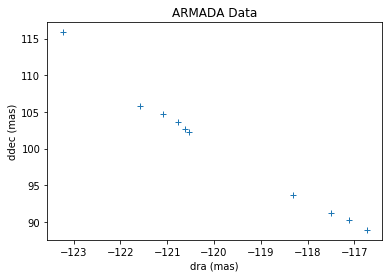

In [8]:
## apply etalon correction
#etalon_factor=1

p = p/etalon_factor

xpos=p*np.sin(theta)
ypos=p*np.cos(theta)

plt.plot(xpos,ypos,'+')
#plt.plot(0,0,'*')
plt.title('ARMADA Data')
plt.xlabel('dra (mas)')
plt.ylabel('ddec (mas)')
plt.show()

## Read in WDS data

In [9]:
## get wds data
#Get data from txt file:
file=open(os.path.expanduser("%s/wds%s.txt"%(path_wds,target_wds[focus])))
weight = 10
dtype = 'S'

t_wds,p_wds,theta_wds,error_maj_wds,error_min_wds,error_pa_wds,error_deg_wds = read_wds(file,weight,dtype)

In [10]:
print(len(p_wds))

31


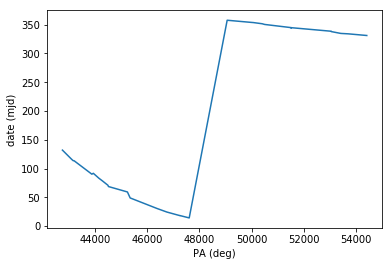

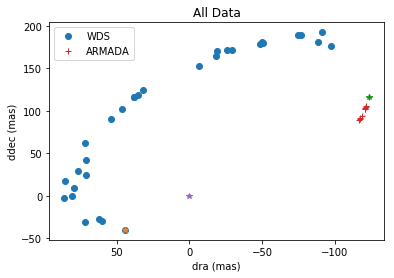

In [11]:
## plot all data
    
if target_hd[focus] == '17094':
    idx = np.where(theta_wds*180/np.pi>180)
    theta_wds[idx]-=np.pi
    plt.plot(t_wds,theta_wds*180/np.pi)
    plt.show()
    
else:
    plt.plot(t_wds,theta_wds*180/np.pi)
    plt.xlabel('PA (deg)')
    plt.ylabel('date (mjd)')
    plt.show()

xpos_wds=p_wds*np.sin(theta_wds)
ypos_wds=p_wds*np.cos(theta_wds)

#idx = np.where(xpos_wds>-100)
#xpos_wds = xpos_wds[idx]
#ypos_wds = ypos_wds[idx]
#t_wds = t_wds[idx]
#error_maj_wds=error_maj_wds[idx]
#error_min_wds=error_min_wds[idx]
#error_pa_wds=error_pa_wds[idx]
#error_deg_wds=error_deg_wds[idx]

idx = np.argmin(t)

plt.plot(xpos_wds,ypos_wds,'o',label='WDS')
plt.plot(xpos_wds[0],ypos_wds[0],'*')
plt.plot(xpos[idx],ypos[idx],'*')
plt.plot(xpos,ypos,'+',label='ARMADA')
plt.plot(0,0,'*')
plt.gca().invert_xaxis()
plt.title('All Data')
plt.xlabel('dra (mas)')
plt.ylabel('ddec (mas)')
plt.legend()
plt.show()

In [12]:
## flip WDS by 180???
if target_hd[focus] == '17094' or target_hd[focus] == '185762':
    xpos_wds=-p_wds*np.sin(theta_wds)
    ypos_wds=-p_wds*np.cos(theta_wds)

    plt.plot(xpos_wds,ypos_wds,'o')
    plt.plot(xpos_wds[0],ypos_wds[0],'*')
    plt.plot(xpos[idx],ypos[idx],'*')
    plt.plot(xpos,ypos,'+')
    plt.plot(0,0,'*')
    plt.gca().invert_xaxis()
    plt.title('All Data')
    plt.xlabel('dra (mas)')
    plt.ylabel('ddec (mas)')
    plt.show()

## Get an estimate of the orbital parameters

In [13]:
if target_hd[focus] == '17094':
    # Guess for hd17094
    P = 12356
    e = 0.9
    inc = 264*np.pi/180
    omega = 260*np.pi/180
    bigomega = 240*np.pi/180
    a = 543
    T = 21541
    
else:
    a,P,e,inc,omega,bigomega,T = read_orb6(target[focus],path_orb6)

found target!
--------------------------
a(mas),P(yr),e,i(deg),omega(deg),bigomega(deg),T(mjd)
154.0 52.73500000000001 0.653 124.22000000000001 309.07000000000005 127.07999999999998 42386.31231940002
--------------------------


## Combine the ARMADA and WDS data for fitting

In [14]:
## add all data together
xpos_all = np.concatenate([xpos,xpos_wds])
ypos_all = np.concatenate([ypos,ypos_wds])
t_all = np.concatenate([t,t_wds])

error_maj_all = np.concatenate([error_maj,error_maj_wds])
error_min_all = np.concatenate([error_min,error_min_wds])
error_pa_all = np.concatenate([error_pa,error_pa_wds])
error_deg_all = np.concatenate([error_deg,error_deg_wds])

## First, do a least-squares fit

In [15]:
#create a set of Parameters, choose starting value and range for search
params = Parameters()
params.add('w',   value= omega, min=0, max=2*np.pi)
params.add('bigw', value= bigomega, min=0, max=2*np.pi)
params.add('inc', value= inc, min=0, max=2*np.pi)
params.add('e', value= e, min=0, max=0.99)
params.add('a', value= a, min=0)
params.add('P', value= P, min=0)
params.add('T', value= T, min=0)

#params.add('pscale', value=1)

#do fit, minimizer uses LM for least square fitting of model to data
minner = Minimizer(astrometry_model, params, fcn_args=(xpos_all,ypos_all,t_all,
                                                       error_maj_all,error_min_all,
                                                       error_pa_all))
kws  = {'options': {'maxiter':10}}
result = minner.minimize()

# write error report
print(report_fit(result))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 82
    # variables        = 7
    chi-square         = 23.4716826
    reduced chi-square = 0.31295577
    Akaike info crit   = -88.5758129
    Bayesian info crit = -71.7287782
[[Variables]]
    w:     5.45662510 +/- 0.03082074 (0.56%) (init = 5.394289)
    bigw:  2.26761233 +/- 0.02354388 (1.04%) (init = 2.217964)
    inc:   2.19362825 +/- 0.00563972 (0.26%) (init = 2.168048)
    e:     0.62595624 +/- 0.01281995 (2.05%) (init = 0.653)
    a:     148.348576 +/- 0.64211558 (0.43%) (init = 154)
    P:     19425.5553 +/- 141.461791 (0.73%) (init = 19248.28)
    T:     42285.6645 +/- 73.6583520 (0.17%) (init = 42386.31)
[[Correlations]] (unreported correlations are < 0.100)
    C(bigw, e) = -0.973
    C(w, bigw) =  0.972
    C(e, P)    = -0.959
    C(bigw, P) =  0.919
    C(P, T)    = -0.907
    C(w, e)    = -0.893
    C(w, P)    =  0.819
    C(w, a)    = -0.789
    C(e, T)    =  0.776
 

In [16]:
resids_armada = astrometry_model(result.params,xpos,ypos,t,error_maj,
                                 error_min,error_pa)
resids_wds = astrometry_model(result.params,xpos_wds,ypos_wds,t_wds,
                              error_maj_wds,error_min_wds,error_pa_wds)

ndata_armada = 2*sum(~np.isnan(xpos))
ndata_wds = 2*sum(~np.isnan(xpos_wds))

chi2_armada = np.nansum(resids_armada**2)/(ndata_armada-len(result.params))
chi2_wds = np.nansum(resids_wds**2)/(ndata_wds-len(result.params))

print('-'*10)
print('chi2 armada = %s'%chi2_armada)
print('-'*10)
print('chi2 wds = %s'%chi2_wds)
print('-'*10)

----------
chi2 armada = 1.2795659059422624
----------
chi2 wds = 0.12431501510868088
----------


## Take a look at the least squares fit

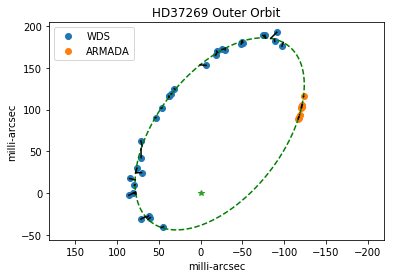

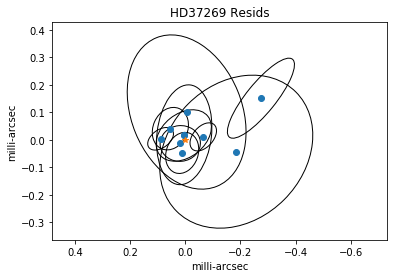

----------
Mean residual = 66.81 micro-as
----------


In [17]:
scale=1
if chi2_armada<1.0:
    scale=1/np.sqrt(chi2_armada)

a_start = result.params['a']
P_start = result.params['P']
e_start = result.params['e']
inc_start = result.params['inc']
w_start = result.params['w']
bigw_start = result.params['bigw']
T_start = result.params['T']
#pscale_start = result.params['pscale']

ra,dec,rapoints,decpoints = orbit_model(a_start,e_start,inc_start,
                                        w_start,bigw_start,P_start,
                                        T_start,t_all)

fig,ax=plt.subplots()

ax.plot(xpos_wds, ypos_wds, 'o', label='WDS')
ax.plot(xpos,ypos,'o', label='ARMADA')
ax.plot(0,0,'*')
ax.plot(ra, dec, '--',color='g')

#plot lines from data to best fit orbit
i=0
while i<len(decpoints):
    x=[xpos_all[i],rapoints[i]]
    y=[ypos_all[i],decpoints[i]]
    ax.plot(x,y,color="black")
    i+=1

directory='%s/HD%s/'%(path,target_hd[focus])
if not os.path.exists(directory):
    os.makedirs(directory)
ax.set_xlabel('milli-arcsec')
ax.set_ylabel('milli-arcsec')
ax.invert_xaxis()
ax.axis('equal')
ax.set_title('HD%s Outer Orbit'%target_hd[focus])
plt.legend()
plt.savefig('%s/HD%s/HD%s_outer_leastsquares.pdf'%(path,target_hd[focus],target_hd[focus]))
plt.show()

## plot resids for ARMADA
fig,ax=plt.subplots()
xresid = xpos - rapoints[:len(xpos)]
yresid = ypos - decpoints[:len(ypos)]

#need to measure error ellipse angle east of north
for ras, decs, w, h, angle in zip(xresid,yresid,error_maj/scale,error_min/scale,error_deg):
    ellipse = Ellipse(xy=(ras, decs), width=2*w, height=2*h, 
                      angle=90-angle, facecolor='none', edgecolor='black')
    ax.add_patch(ellipse)

ax.plot(xresid, yresid, 'o')
ax.plot(0,0,'*')
ax.set_xlabel('milli-arcsec')
ax.set_ylabel('milli-arcsec')
ax.invert_xaxis()
ax.axis('equal')
ax.set_title('HD%s Resids'%target_hd[focus])
plt.savefig('%s/HD%s/HD%s_resid_leastsquares.pdf'%(path,target_hd[focus],target_hd[focus]))
plt.show()

## residuals
resids = np.sqrt(xresid**2 + yresid**2)
resids_median = np.around(np.median(resids)*1000,2)
print('-'*10)
print('Mean residual = %s micro-as'%resids_median)
print('-'*10)

In [18]:
## write a txt file output with best orbit
f = open("%s/HD%s/%s_orbit_ls.txt"%(path,target_hd[focus],target_hd[focus]),"w+")
f.write("# P(d) a(mas) e i(deg) w(deg) W(deg) T(mjd) mean_resid(mu-as)\r\n")
f.write("%s %s %s %s %s %s %s %s"%(P_start.value,a_start.value,e_start.value,
                                   inc_start.value*180/np.pi,w_start.value*180/np.pi,
                                   bigw_start.value*180/np.pi,T_start.value,
                                  resids_median))
f.close()

## Search for Third companion

In [19]:
P2 = np.linspace(1,500,1000)

w2 = w_start
bigw2 = bigw_start
inc2 = inc_start
e2 = 0.01
a2 = resids_median/1000
T2 = t[-1]

In [20]:
params_inner=[]
params_outer=[]
chi2 = []

for period in tqdm(P2):
    params = Parameters()
    params.add('w',   value= w_start, min=0, max=2*np.pi)
    params.add('bigw', value= bigw_start, min=0, max=2*np.pi)
    params.add('inc', value= inc_start, min=0, max=2*np.pi)
    params.add('e', value= e_start, min=0, max=0.99)
    params.add('a', value= a_start, min=0)
    params.add('P', value= P_start, min=0)
    params.add('T', value= T_start, min=0)
    params.add('w2',   value= 0, vary=False)
    params.add('bigw2', value= bigw2, min=0, max=2*np.pi)
    params.add('inc2', value= inc2, min=0, max=2*np.pi)
    params.add('e2', value= 0, vary=False)
    params.add('a2', value= a2, min=0)
    params.add('P2', value= period, vary=False)
    params.add('T2', value= T2, min=0)

    #params.add('pscale', value=1)

    #do fit, minimizer uses LM for least square fitting of model to data
    minner = Minimizer(triple_model, params, fcn_args=(xpos_all,ypos_all,t_all,
                                                       error_maj_all,error_min_all,
                                                       error_pa_all),
                      nan_policy='omit')
    kws  = {'options': {'maxiter':10}}
    result = minner.leastsq(xtol=1e-5,ftol=1e-5)

    params_inner.append([period,result.params['a2'],result.params['e2'],result.params['w2']
                        ,result.params['bigw2'],result.params['inc2'],result.params['T2']])
    params_outer.append([result.params['P'],result.params['a'],result.params['e'],result.params['w']
                        ,result.params['bigw'],result.params['inc'],result.params['T']])
    chi2.append(result.redchi)

100%|██████████| 1000/1000 [08:30<00:00,  1.39it/s]


In [21]:
## plot results
params_inner=np.array(params_inner)
params_outer=np.array(params_outer)
chi2 = np.array(chi2)

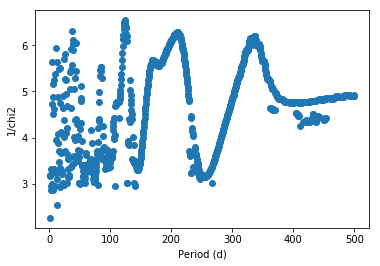

In [22]:
plt.plot(params_inner[:,0],1/chi2,'o')
plt.xlabel('Period (d)')
plt.ylabel('1/chi2')
plt.savefig('%s/HD%s/HD%s_chi2_period.pdf'%(path,target_hd[focus],target_hd[focus]))
#plt.ylim(0,5)
plt.show()

In [23]:
## best period
idx = np.where(chi2==min(chi2))
period_best = params_inner[:,0][idx]
print(period_best)

[123.87687688]


In [24]:
## Do a fit at best period
params = Parameters()
params.add('w',   value= w_start, min=0, max=2*np.pi)
params.add('bigw', value= bigw_start, min=0, max=2*np.pi)
params.add('inc', value= inc_start, min=0, max=2*np.pi)
params.add('e', value= e_start, min=0, max=0.99)
params.add('a', value= a_start, min=0)
params.add('P', value= P_start, min=0)
params.add('T', value= T_start, min=0)
params.add('w2',   value= 0, vary=False)#w2, min=0, max=2*np.pi)
params.add('bigw2', value= bigw2, min=0, max=2*np.pi)
params.add('inc2', value= inc2, min=0, max=2*np.pi)
params.add('e2', value= 0, vary=False)#0.1, min=0,max=0.99)
params.add('a2', value= a2, min=0)
params.add('P2', value= period_best, min=0)
params.add('T2', value= T2, min=0)

#params.add('pscale', value=1)

#do fit, minimizer uses LM for least square fitting of model to data
minner = Minimizer(triple_model, params, fcn_args=(xpos_all,ypos_all,t_all,
                                                   error_maj_all,error_min_all,
                                                   error_pa_all),
                  nan_policy='omit')
kws  = {'options': {'maxiter':10}}
result = minner.minimize()

best_inner = [result.params['P2'],result.params['a2'],result.params['e2'],result.params['w2']
                    ,result.params['bigw2'],result.params['inc2'],result.params['T2']]
best_outer = [result.params['P'],result.params['a'],result.params['e'],result.params['w']
                    ,result.params['bigw'],result.params['inc'],result.params['T']]
report_fit(result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 166
    # data points      = 82
    # variables        = 12
    chi-square         = 10.9511925
    reduced chi-square = 0.15644561
    Akaike info crit   = -141.088213
    Bayesian info crit = -112.207582
[[Variables]]
    w:      5.46240053 +/- 0.02208834 (0.40%) (init = 5.456625)
    bigw:   2.27150048 +/- 0.01687616 (0.74%) (init = 2.267612)
    inc:    2.19546328 +/- 0.00404507 (0.18%) (init = 2.193628)
    e:      0.62390097 +/- 0.00917061 (1.47%) (init = 0.6259562)
    a:      148.228141 +/- 0.44407201 (0.30%) (init = 148.3486)
    P:      19450.7626 +/- 101.808415 (0.52%) (init = 19425.56)
    T:      42277.1640 +/- 52.8674364 (0.13%) (init = 42285.66)
    w2:     0 (fixed)
    bigw2:  1.52766265 +/- 0.17255229 (11.30%) (init = 2.267612)
    inc2:   1.71884441 +/- 0.14782989 (8.60%) (init = 2.193628)
    e2:     0 (fixed)
    a2:     0.11599620 +/- 0.01622787 (13.99%) (init = 0.06681)
    P2:     124.7

## Take a look at best fit

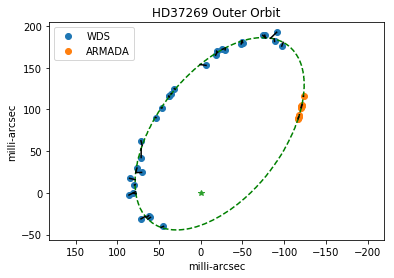

(1000,)
(1000,)


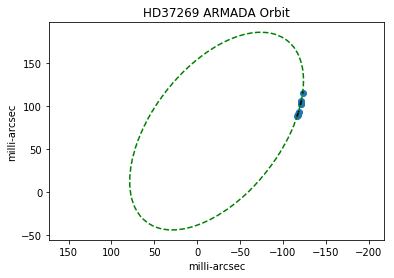

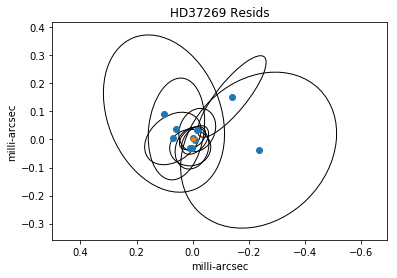

----------
Mean residual = 53.11 micro-as
----------


In [25]:
scale=1
if chi2_armada<1.0:
    scale=1/np.sqrt(chi2_armada)

a_start = result.params['a']
P_start = result.params['P']
e_start = result.params['e']
inc_start = result.params['inc']
w_start = result.params['w']
bigw_start = result.params['bigw']
T_start = result.params['T']
a2_start = result.params['a2']
P2_start = result.params['P2']
e2_start = result.params['e2']
inc2_start = result.params['inc2']
w2_start = result.params['w2']
bigw2_start = result.params['bigw2']
T2_start = result.params['T2']
#pscale_start = result.params['pscale']

ra,dec,rapoints,decpoints = triple_orbit_model(a_start,e_start,inc_start,
                                        w_start,bigw_start,P_start,
                                        T_start,a2_start,e2_start,inc2_start,
                                        w2_start,bigw2_start,P2_start,
                                        T2_start,t_all)
ra_armada,dec_armada,rapoints_armada,decpoints_armada = triple_orbit_model(a_start,e_start,
                                                                           inc_start,w_start,
                                                                           bigw_start,P_start,
                                                                           T_start,a2_start,
                                                                           e2_start,inc2_start,
                                                                           w2_start,bigw2_start,
                                                                           P2_start,T2_start,t)

fig,ax=plt.subplots()

ax.plot(xpos_wds, ypos_wds, 'o', label='WDS')
ax.plot(xpos,ypos,'o', label='ARMADA')
ax.plot(0,0,'*')
ax.plot(ra, dec, '--',color='g')

#plot lines from data to best fit orbit
i=0
while i<len(decpoints):
    x=[xpos_all[i],rapoints[i]]
    y=[ypos_all[i],decpoints[i]]
    ax.plot(x,y,color="black")
    i+=1

ax.set_xlabel('milli-arcsec')
ax.set_ylabel('milli-arcsec')
ax.invert_xaxis()
ax.axis('equal')
ax.set_title('HD%s Outer Orbit'%target_hd[focus])
plt.legend()
plt.savefig('%s/HD%s/HD%s_outer_leastsquares_triple.pdf'%(path,target_hd[focus],target_hd[focus]))
plt.show()

####################################
fig,ax=plt.subplots()

print(ra_armada.shape)
print(ra.shape)

ax.plot(xpos,ypos,'o')
ax.plot(ra_armada, dec_armada, '--',color='g')

#plot lines from data to best fit orbit
i=0
while i<len(decpoints_armada):
    x=[xpos[i],rapoints_armada[i]]
    y=[ypos[i],decpoints_armada[i]]
    ax.plot(x,y,color="black")
    i+=1

ax.set_xlabel('milli-arcsec')
ax.set_ylabel('milli-arcsec')
ax.invert_xaxis()
ax.axis('equal')
ax.set_title('HD%s ARMADA Orbit'%target_hd[focus])
plt.savefig('%s/HD%s/HD%s_armada_leastsquares_triple.pdf'%(path,target_hd[focus],target_hd[focus]))
plt.show()

## plot resids for ARMADA
fig,ax=plt.subplots()
xresid = xpos - rapoints_armada
yresid = ypos - decpoints_armada

#need to measure error ellipse angle east of north
for ras, decs, w, h, angle in zip(xresid,yresid,error_maj/scale,error_min/scale,error_deg):
    ellipse = Ellipse(xy=(ras, decs), width=2*w, height=2*h, 
                      angle=90-angle, facecolor='none', edgecolor='black')
    ax.add_patch(ellipse)

ax.plot(xresid, yresid, 'o')
ax.plot(0,0,'*')
ax.set_xlabel('milli-arcsec')
ax.set_ylabel('milli-arcsec')
ax.invert_xaxis()
ax.axis('equal')
ax.set_title('HD%s Resids'%target_hd[focus])
plt.savefig('%s/HD%s/HD%s_resid_leastsquares_triple.pdf'%(path,target_hd[focus],target_hd[focus]))
plt.show()

## residuals
resids = np.sqrt(xresid**2 + yresid**2)
resids_median = np.around(np.median(resids)*1000,2)
print('-'*10)
print('Mean residual = %s micro-as'%resids_median)
print('-'*10)

## Grid Search on a and i

In [26]:
## grid of a and inc
a_grid = np.linspace(0.1,3,50)
i_grid = np.linspace(0,180,50)

params_inner=[]
params_outer=[]
chi2 = []

for semi in tqdm(a_grid):
    for angle in i_grid:
        params = Parameters()
        params.add('w',   value= best_outer[3], vary=False)#min=0, max=2*np.pi)
        params.add('bigw', value= best_outer[4], vary=False)#min=0, max=2*np.pi)
        params.add('inc', value= best_outer[5], vary=False)#min=0, max=2*np.pi)
        params.add('e', value= best_outer[2], vary=False)#min=0, max=0.99)
        params.add('a', value= best_outer[1], vary=False)#min=0)
        params.add('P', value= best_outer[0], vary=False)#min=0)
        params.add('T', value= best_outer[6], vary=False)#min=0)
        params.add('w2',   value= best_inner[3], vary=False)
        params.add('bigw2', value= best_inner[4], min=0, max=2*np.pi)
        params.add('inc2', value= angle*np.pi/180, vary=False)#min=0, max=2*np.pi)
        params.add('e2', value= 0, vary=False)
        params.add('a2', value= semi, vary=False)#a2, min=0)
        params.add('P2', value= best_inner[0], min=0)
        params.add('T2', value= best_inner[3], min=0)

        #params.add('pscale', value=1)

        #do fit, minimizer uses LM for least square fitting of model to data
        minner = Minimizer(triple_model, params, fcn_args=(xpos_all,ypos_all,t_all,
                                                           error_maj_all,error_min_all,
                                                           error_pa_all),
                          nan_policy='omit')
        kws  = {'options': {'maxiter':10}}
        result = minner.leastsq(xtol=1e-5,ftol=1e-5)

        params_inner.append([result.params['P2'],semi,result.params['e2'],result.params['w2']
                            ,result.params['bigw2'],angle,result.params['T2']])
        params_outer.append([result.params['P'],result.params['a'],result.params['e'],result.params['w']
                            ,result.params['bigw'],result.params['inc'],result.params['T']])
        chi2.append(result.redchi)

  4%|▍         | 2/50 [00:30<11:28, 14.34s/it]

KeyboardInterrupt: 

In [27]:
params_inner = np.array(params_inner)
params_outer = np.array(params_outer)
chi2 = np.array(chi2)

print(params_inner.shape)
print(chi2.shape)

(114, 7)
(114,)


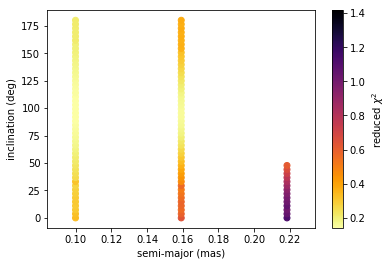

In [28]:
a_inner = params_inner[:,1]
i_inner = params_inner[:,5]

plt.scatter(a_inner,i_inner,c=chi2,cmap=cm.inferno_r,vmax=min(chi2)*10)
plt.colorbar(label='reduced $\chi^2$')
plt.xlabel('semi-major (mas)')
plt.ylabel('inclination (deg)')
plt.savefig('%s/HD%s/HD%s_semi_inc_grid.pdf'%(path,target_hd[focus],target_hd[focus]))
plt.show()